<a href="https://colab.research.google.com/github/asidosaputra/Rock-Physics-Modelling/blob/master/GassmanSubtitution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01 Import Library

In [4]:
!pip install lasio

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import lasio

## 02 Membuat Fungsi Gassmann

In [0]:
class Gassmann:
    '''
    An object to modelling effect of fluid subtitution in wave propogatiion using gassman equation. 

    Author      : Asido Saputra Sigalingging, S.T(Reservoir Charactization Dept., 2020)
    Refferences : The Rock Physics Handbook 2rd Edition(2009). by Gary Mavko

    '''
    def __init__(self):
        self.__k0           = None
        self.__kdry         = None
        self.__ksat_init    = None
        self.__ksat_new     = None
        self.__musat_init   = None

        self.__kfl_init     = None
        self.__kfl_new      = None

        self.__mu0          = None
        self.__phi          = None

        self.__rhofl_new    = None
        self.__rho0         = None
    
    def saturated_moduli_init(self, vp_init, vs_init, rho_init):
        '''
        Exstract saturated modulus from well log data
        params:
        vp_init     : P-Wave velocity saturated from log data[km/s], 1D np.array
        vs_init     : S-Wave velocity saturated from log data[km/s], 1D np.array
        rho_init    : Bulk density saturated from log data[km/s], 1D np.array

        Output(No return)
        ksat_init   : Initial Bulk modulus saturated [GPa]
        musat_init  : Initial Shear modulus saturated [GPa]  

        '''
        ksat_init  = rho_init*(vp_init ** 2 - (4/3)* (vs_init **2) )
        musat_init = rho_init*(vs_init ** 2)

        self.__ksat_init  = ksat_init
        self.__musat_init = musat_init

        return ksat_init, musat_init


    def frame_moduly(self, phi, rho0, k0, kfl_init):
        '''
        Calculate frame/dry modulus
        params:
        phi         : porosity
        k0          : bulk modulus of mineral
        kfl_init    : bulk moduly of fluid 
        '''
        self.__phi = phi
        self.__rho0 = rho0
        self.__k0 = k0
        self.__kfl_init = kfl_init 

        F1 = self.__phi*(self.__k0/self.__kfl_init)
        F2 = self.__ksat_init / self.__k0
        kdry = (self.__ksat_init*(F1 + 1 - self.__phi) - self.__k0) / (F1 + F2 - 1 - self.__phi)

        self.__kdry = kdry
        
        return kdry

    def saturated_moduli(self, kfl_new, rhofl_new):
        '''
        Calculate saturated moduly of new fluid subtitution
        
        params
        ------
        kfl : Bulk moduly of new fluid subtition

        return
        ------
        Bulk modulus of saturated rock which was fill new fluid [GPa]

        '''
        self.__kfl_new = kfl_new
        self.__rhofl_new = rhofl_new

        F1 = (1 - self.__kdry/self.__k0) ** 2
        F2 = (self.__phi / kfl_new) + ((1 - self.__phi) / self.__k0) - (self.__kdry/self.__k0**2)  
        
        ksat = self.__kdry + (F1 / F2)
        self.__ksat_new = ksat

        return ksat
    
    def saturated_velocity(self):
        #evaluate bulk density which disired fluid subtitution 
        rhosat_new = self.__phi*self.__rhofl_new + (1 - self.__phi)*self.__rho0 

        vp = np.sqrt((self.__ksat_new + (4/3)*self.__musat_init)/ rhosat_new)
        vs = np.sqrt((self.__musat_init/ rhosat_new))
        return vp, vs, rhosat_new

## 03 Apilikasi terhadap data sumur

In [7]:
#01 Import Las
path_file = '/content/drive/My Drive/LAS File/1184-U1148.las'
well_01 = lasio.read(path_file)
print(well_01.keys())

well_01 = well_01.df()
well_01 = well_01.dropna()
well_01.head()

['DEPTH', 'APLC', 'HCGR', 'HSGR', 'IDPH', 'IMPH', 'LCAL', 'PEFL', 'RHOM', 'SFLU', 'VP1', 'VP2']


,APLC,HCGR,HSGR,IDPH,IMPH,LCAL,PEFL,RHOM,SFLU,VP1,VP2
DEPTH,,,,,,,,,,,
194.9198,84.6860,42.68512,48.29583,0.9494,0.9648,14.3406,3.4090,1.8494,0.9000,2.223191,2.170771
195.0722,85.1684,40.04132,45.65179,0.9464,0.9765,14.3429,3.4860,1.8552,0.8960,2.229692,2.269371
195.2246,86.7550,39.90472,45.56602,0.9505,0.9877,14.4057,3.5920,1.8593,0.8898,2.247776,2.087939
195.3770,86.7934,39.00853,45.58442,0.9521,0.9962,14.5051,3.5474,1.8707,0.8713,2.211947,2.093393
195.5294,84.3385,40.55323,47.50523,0.9527,0.9993,14.5178,3.5679,1.8605,0.8781,2.269524,2.122562


In [0]:
#Modulus mineral penyusun kerangka batuan berdasarkan data
K_cb = 63.7     ; Mu_cb = 31.7      #GPa            #Carbonate
K_qz =36.5      ; Mu_qz = 44        #GPa            #quartz
K_bi = 44.8     ; Mu_bi = 38.8      #GPa            #detrital corbonate/bio carbonate

#Fraksi mineral
f_cb = 0.15
f_qz = 0.05
f_bi = 0.8

#Bulk Density
rho_qz=2.65
rho_bi=2.92
rho_cb=2.71

In [0]:
#determine bulk modulus of mineral
#hill methods
def voight_reuss_hill(M, f):
    """
    :param M: Input moduli tiap konstituen.
    :param f: Volume fraksi tiap konstituen.
    """
    v = np.sum(M*f)
    r = 1/np.sum(f/M)
    h = (v + r) / 2.
    return(v, r, h)

M = np.array([K_cb,K_qz, K_bi ])
f = np.array([f_cb,f_qz, f_bi ])
rh0 = np.array([rho_cb,rho_qz, rho_bi ])

#bulk moduly of minerals
kv,kr, kh = voight_reuss_hill(M, f)

#bulk density of minerals
rhov, _, _ = voight_reuss_hill(rh0, f)

In [0]:
#02 Prepare Data
vp_init = well_01['VP2']
vs_init = -0.055*(vp_init**2) + 1.017*vp_init - 1.031 #vp-vs castagna relation in limestone
rho_init = well_01['RHOM']
phi = well_01['APLC']/100 - 0.1

#Matrix properties
k0 = kh
rho0 = rhov

#Fluid initial difine as gas saturated, assume type of gas is 
kfl_init = 0.823  #gas

#Fluid subtitution
#water 
kfl_w     = 2.2     
rhofl_w   = 1

#crude oil, type califonia crude oil
kfl_o     = 1.2     
rhofl_o   = 0.915

In [0]:
#03 Modelling Gassmann
gm = Gassmann()

#04 Extract saturated modulus from log data
ksat_init, musat_init = gm.saturated_moduli_init(vp_init, vs_init, rho_init)

#05 Frame modulus
kdry  = gm.frame_moduly(phi, rho0, k0, kfl_init)

#06 Fluid subtition water
ksat_w                    = gm.saturated_moduli(kfl_w, rhofl_w)
vp_w, vs_w, rhosat_new_w    = gm.saturated_velocity()

#07 Fluid subtition gas
ksat_o                    = gm.saturated_moduli(kfl_o, rhofl_o)
vp_o, vs_o, rhosat_new_o  = gm.saturated_velocity()

## 04 Plotting Data

<Figure size 432x288 with 0 Axes>

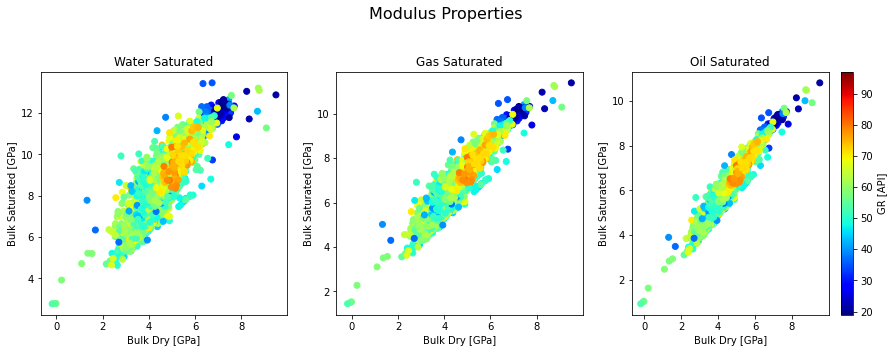

In [12]:
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
fig.subplots_adjust(top=0.80)
ax[0].scatter(kdry, ksat_w, c = well_01['HSGR'], cmap='jet')
ax[0].set_xlabel('Bulk Dry [GPa]')
ax[0].set_ylabel('Bulk Saturated [GPa]')
ax[0].set_title('Water Saturated')

ax[1].scatter(kdry, ksat_o, c = well_01['HSGR'], cmap='jet')
ax[1].set_xlabel('Bulk Dry [GPa]')
ax[1].set_ylabel('Bulk Saturated [GPa]')
ax[1].set_title('Gas Saturated')

im = ax[2].scatter(kdry, ksat_init, c = well_01['HSGR'] , cmap='jet')
ax[2].set_xlabel('Bulk Dry [GPa]')
ax[2].set_ylabel('Bulk Saturated [GPa]')
ax[2].set_title('Oil Saturated')

fig.colorbar(im, label = 'GR [API]')
fig.suptitle('Modulus Properties', size=16)
fig.show()

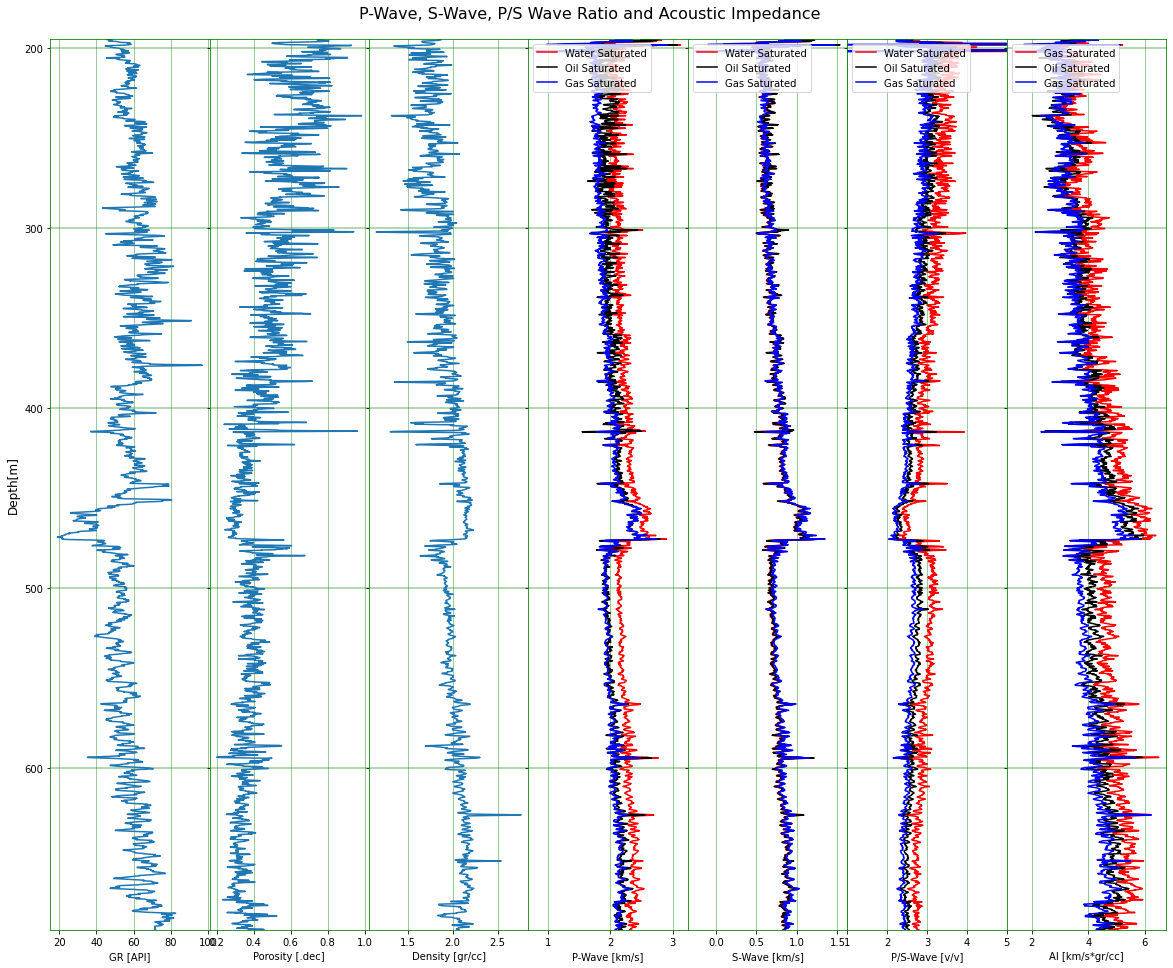

In [13]:
fig, ax = plt.subplots(nrows=1, ncols= 7, figsize=(20, 15), sharey=True)
fig.subplots_adjust(wspace=0, top=0.95)

for axes in ax:
    axes.set_ylim(min(well_01.index), max(well_01.index))
    axes.invert_yaxis()
    axes.yaxis.grid(True, color='g', alpha=0.3, linewidth=2)
    axes.xaxis.grid(True, color='g', alpha=0.5)
    for spine in axes.spines.values():
        spine.set_edgecolor('green')

ax[0].plot(well_01['HSGR'], well_01.index)
ax[0].set_ylabel("Depth[m]", color='k', size=12)
ax[0].set_xlabel('GR [API]')

ax[1].plot(phi, well_01.index)
ax[1].set_xlabel('Porosity [.dec]')

ax[2].plot(well_01['RHOM'], well_01.index)
ax[2].set_xlabel('Density [gr/cc]')

ax[3].plot(vp_w, well_01.index, 'r', label='Water Saturated')
ax[3].plot(vp_o, well_01.index, 'k', label='Oil Saturated')
ax[3].plot(vp_init, well_01.index, 'b', label='Gas Saturated')
ax[3].legend(loc=2)
ax[3].set_xlabel('P-Wave [km/s]')

ax[4].plot(vs_w, well_01.index, 'r', label='Water Saturated')
ax[4].plot(vs_o, well_01.index, 'k', label='Oil Saturated')
ax[4].plot(vs_init, well_01.index, 'b', label='Gas Saturated')
ax[4].legend(loc=2)
ax[4].set_xlabel('S-Wave [km/s]')

ax[5].plot(vp_w/vs_w, well_01.index, 'r', label='Water Saturated')
ax[5].plot(vp_o/vs_o, well_01.index, 'k', label='Oil Saturated')
ax[5].plot(vp_init/vs_init, well_01.index, 'b', label='Gas Saturated')
ax[5].legend(loc=2)
ax[5].set_xlabel('P/S-Wave [v/v]')
ax[5].set_xlim(1, 5)

ax[6].plot(vp_w*rhosat_new_w, well_01.index, 'r', label='Gas Saturated')
ax[6].plot(vp_o*rhosat_new_o, well_01.index, 'k', label='Oil Saturated')
ax[6].plot(vp_init*rho_init, well_01.index, 'b', label='Gas Saturated')
ax[6].legend(loc=2)
ax[6].set_xlabel('AI [km/s*gr/cc]')

fig.suptitle('P-Wave, S-Wave, P/S Wave Ratio and Acoustic Impedance', size = 16)
fig.show()